In [1]:
# imports & load
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

CSV = "../data/data_files/backtest_bets.csv"
df = pd.read_csv(CSV, parse_dates=["date","month_start"]).sort_values("date")

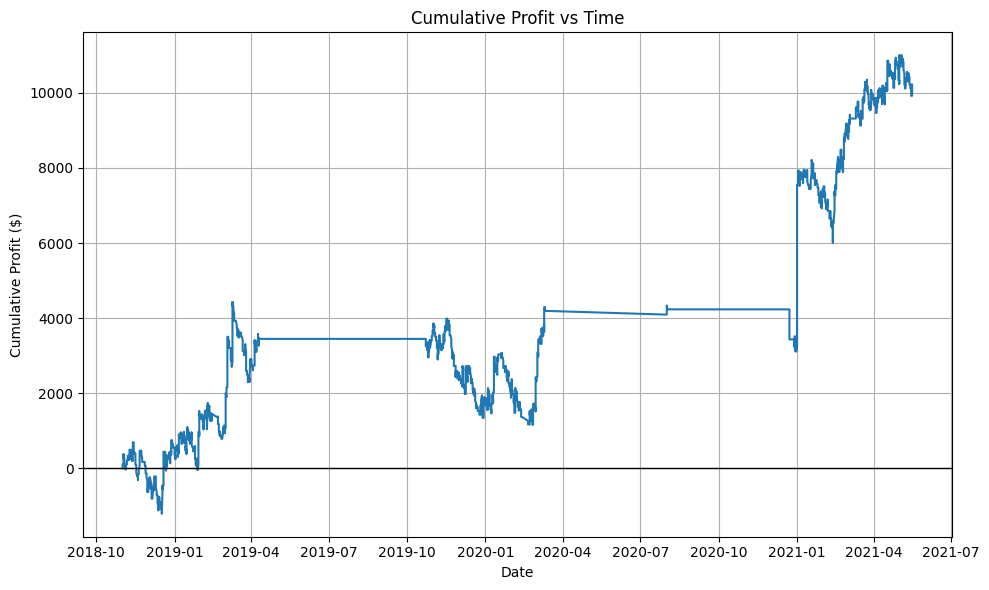

In [2]:
# backtest cumulative profit plot
plt.figure(figsize=(10,6))
df["cum_profit"] = df["profit"].cumsum()
plt.plot(df["date"], df["cum_profit"])
plt.axhline(0, linewidth=1, color='k')
plt.xlabel("Date"); plt.ylabel("Cumulative Profit ($)")
plt.title("Cumulative Profit vs Time")
plt.grid(True); plt.tight_layout(); plt.show()

In [45]:
import pandas as pd
import numpy as np

# --- load backtest bets ---
CSV_PATH = "../data/data_files/backtest_bets.csv"
SEASONS = [2019, 2020, 2021]  # change if needed

df = pd.read_csv(CSV_PATH, parse_dates=["date"])

# add season if missing (Oct–Dec -> next year; Jan–Sep -> same year)
if "season" not in df.columns:
    def season_year(dt: pd.Timestamp) -> int:
        return dt.year + 1 if dt.month >= 10 else dt.year
    df["season"] = df["date"].apply(season_year)

# keep placed bets only and target seasons
bets = df[df["bet_team"].isin(["A","B"])].copy()
bets = bets[bets["season"].isin(SEASONS)]
if bets.empty:
    raise ValueError(f"No placed bets in seasons {SEASONS}.")

# --- per-season stats ---
season_stats = (
    bets.groupby("season")
        .agg(total_profit=("profit", "sum"),
             n_bets=("profit", "count"))
        .assign(ROI=lambda g: g["total_profit"] / (100.0 * g["n_bets"]))
        .reindex(SEASONS)  # keep order
)

# print bets per season
for season, n in season_stats["n_bets"].items():
    print(f"Season {season}: bets placed = {int(n)}")

# average ROI across seasons
avg_roi = season_stats["ROI"].mean()
print(f"Average ROI across {len(SEASONS)} seasons: {avg_roi:.6f}")

# --- 3-year Sharpe scaled by total game days (days with >=1 bet) ---
bets["date_only"] = bets["date"].dt.date
daily = (
    bets.groupby("date_only")
        .agg(profit_sum=("profit", "sum"),
             n_bets=("profit", "count"))
        .assign(daily_ret=lambda g: g["profit_sum"] / (100.0 * g["n_bets"]))
)
daily_ret = daily["daily_ret"].dropna()
n_game_days = len(daily_ret)

if n_game_days == 0:
    three_year_sharpe = np.nan
else:
    mu = daily_ret.mean()
    sigma = daily_ret.std(ddof=1)
    three_year_sharpe = np.nan if sigma == 0 else (mu / sigma) * np.sqrt(n_game_days)
print(f"Sharpe: {three_year_sharpe:.6f}")

Season 2019: bets placed = 303
Season 2020: bets placed = 277
Season 2021: bets placed = 351
Average ROI across 3 seasons: 0.102329
Sharpe: 1.389376


In [4]:
# print the Win/Loss accuracy
import numpy as np
import pandas as pd

# Require prediction & outcome columns
need = {"pred_score_diff", "score_diff"}
missing = need - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Keep rows with both prediction and actual outcome
eval_df = df.dropna(subset=["pred_score_diff", "score_diff"]).copy()

# Map to winners: A if margin>0, B if margin<0; drop exact ties (==0) if any
eval_df["pred_winner"] = np.where(eval_df["pred_score_diff"] > 0, "A",
                           np.where(eval_df["pred_score_diff"] < 0, "B", np.nan))
eval_df["actual_winner"] = np.where(eval_df["score_diff"] > 0, "A",
                             np.where(eval_df["score_diff"] < 0, "B", np.nan))

eval_df = eval_df.dropna(subset=["pred_winner", "actual_winner"])

overall_acc = (eval_df["pred_winner"] == eval_df["actual_winner"]).mean()
print(f"Win/Loss Prediction accuracy: {overall_acc:.4%}")


Overall prediction accuracy: 65.2704% (n=3199)


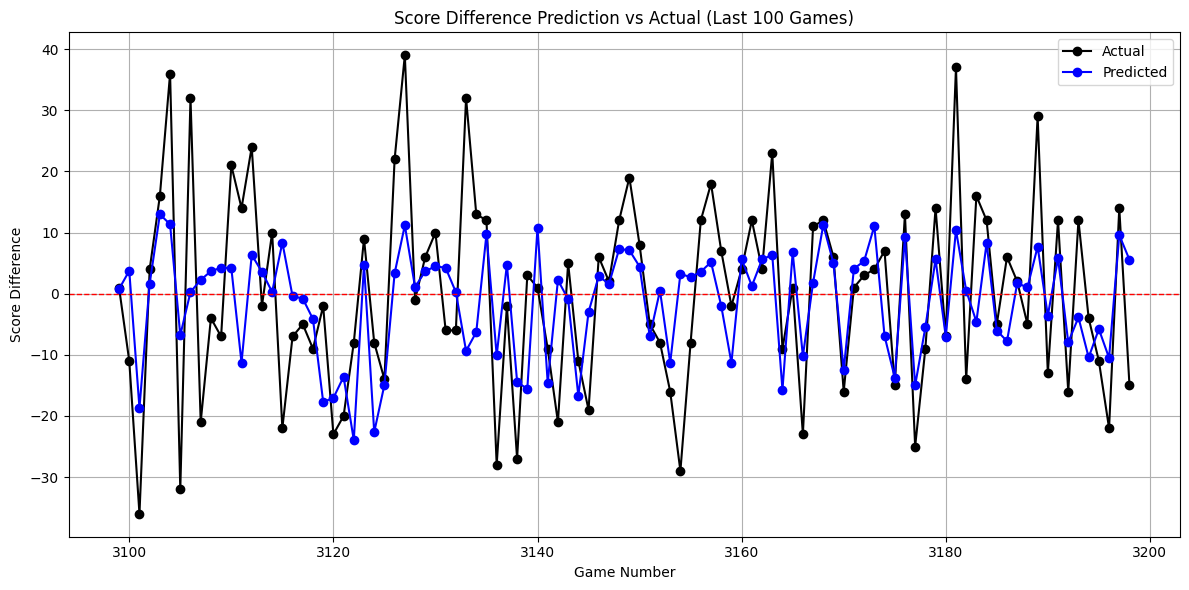

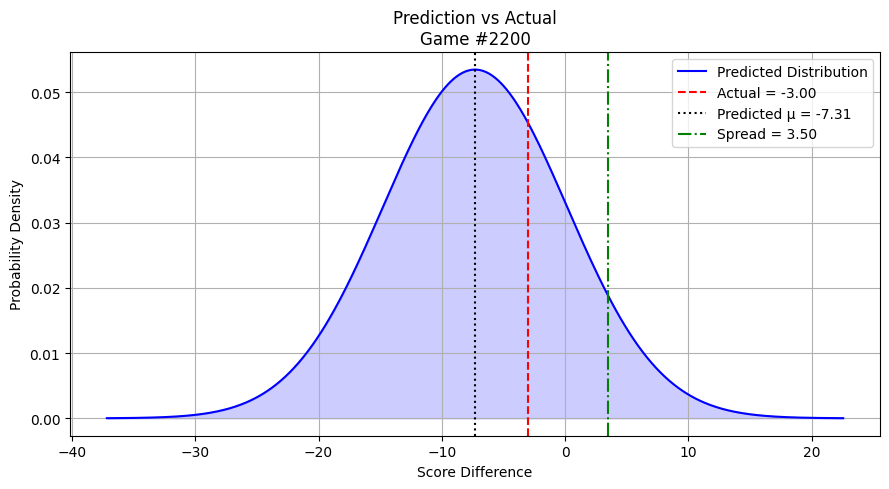

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

CSV_PATH = "../data/data_files/backtest_bets.csv"

# Must have these columns
required = {"date", "score_diff", "pred_score_diff", "pred_std"}
final_df = pd.read_csv(CSV_PATH, parse_dates=["date"])
missing = required - set(final_df.columns)
if missing:
    raise ValueError(f"{CSV_PATH} is missing required columns: {missing}")

# Keep rows that have both predictions and outcomes
final_df = (final_df
            .dropna(subset=["pred_score_diff", "pred_std", "score_diff"])
            .sort_values("date")
            .reset_index(drop=True))

# Add a positional game number for plotting
final_df["game_number"] = np.arange(len(final_df))

# ================= Plot 1: Prediction vs Actual (last 100 games) =================
plot_df = final_df.tail(100).copy()

plt.figure(figsize=(12, 6))
plt.plot(plot_df["game_number"], plot_df["score_diff"], label="Actual", color="black", marker="o")
plt.plot(plot_df["game_number"], plot_df["pred_score_diff"], label="Predicted", color="blue", marker="o")
plt.xlabel("Game Number")
plt.ylabel("Score Difference")
plt.title("Score Difference Prediction vs Actual (Last 100 Games)")
plt.legend()
plt.grid(True)
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.tight_layout()
plt.show()

# ============ Plot 2: Single-match predictive distribution example ============
pos_idx = min(2200, len(final_df) - 1)
row = final_df.iloc[pos_idx]

mu = float(row["pred_score_diff"])
sigma = float(row["pred_std"]) if pd.notna(row["pred_std"]) else 0.0
sigma = max(sigma, 1e-6)  # guardrail to avoid zero/neg std
actual = float(row["score_diff"])
spread = float(row["spread"]) if "spread" in final_df.columns and pd.notna(row["spread"]) else None

x = np.linspace(mu - 4*sigma, mu + 4*sigma, 500)
y = norm.pdf(x, mu, sigma)

plt.figure(figsize=(9, 5))
plt.plot(x, y, label="Predicted Distribution", color="blue")
plt.axvline(actual, color="red", linestyle="--", label=f"Actual = {actual:.2f}")
plt.axvline(mu, color="black", linestyle=":", label=f"Predicted μ = {mu:.2f}")
if spread is not None:
    plt.axvline(spread, color="green", linestyle="-.", label=f"Spread = {spread:.2f}")
plt.fill_between(x, y, alpha=0.2, color="blue")

if {"teamA","teamB"}.issubset(final_df.columns):
    title_teams = f"{row['teamA']} vs {row['teamB']} — "
else:
    title_teams = ""
plt.title(f"Prediction vs Actual\n{title_teams}Game #{int(row['game_number'])}")

plt.xlabel("Score Difference")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()